In [49]:
import numpy as np
import pandas as pd
from random import randint
import math
from PIL import Image, ImageDraw
from PIL import ImagePath 
from imutils import rotate
import matplotlib.pyplot as plt
from skimage.transform import radon



# from dataset_generator import generate_polygon, calculate_angles
from dataset_generator import create_dataset, get_non_binary_angles #, generate_polygon, generate_polygon_subroutine
from utils import mse_error, reconstruct

ImportError: cannot import name 'get_non_binary_angles' from 'dataset_generator' (/Users/szczekulskij/side_projects/tomography-reconstruction-CNN/src/dataset_generator.py)

average mse error for 10 square pics: 0.14


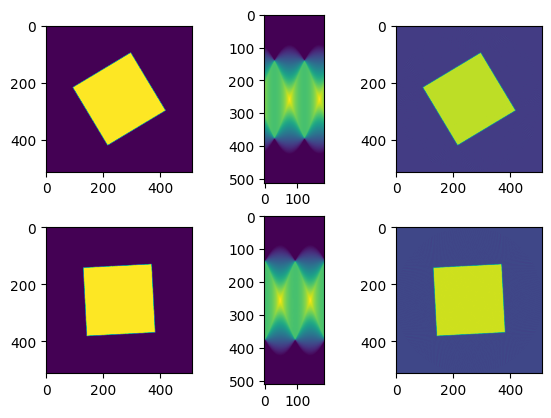

In [2]:
images_list, sinograms_list, angles_list = create_dataset(10, single_side_size = 4, img_size = 256 * 2)
reconstruct_list = reconstruct(sinograms_list)
print("average mse error for 10 square pics:", mse_error(images_list, reconstruct_list))
f, axarr = plt.subplots(2,3)
axarr[0,0].imshow(images_list[0]) 
axarr[0,1].imshow(sinograms_list[0])
axarr[0,2].imshow(reconstruct_list[0])
axarr[1,0].imshow(images_list[1])
axarr[1,1].imshow(sinograms_list[1])
axarr[1,2].imshow(reconstruct_list[1])


average mse error for 50 polygon-shaped pics: 0.16


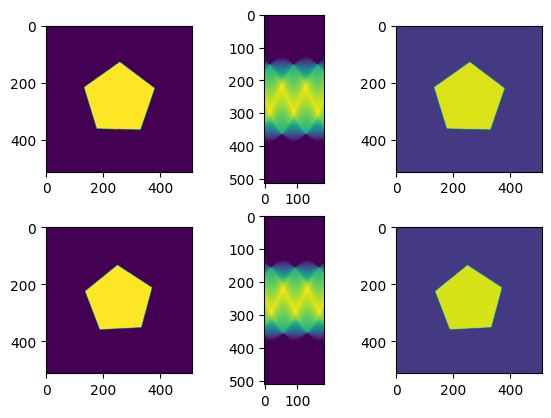

In [3]:
images_list, sinograms_list, angles_list = create_dataset(50, single_side_size = None, img_size = 256 * 2)
reconstruct_list = reconstruct(sinograms_list)
print("average mse error for 50 polygon-shaped pics:", mse_error(images_list, reconstruct_list))
f, axarr = plt.subplots(2,3)
axarr[0,0].imshow(images_list[0]) 
axarr[0,1].imshow(sinograms_list[0])
axarr[0,2].imshow(reconstruct_list[0])
axarr[1,0].imshow(images_list[1])
axarr[1,1].imshow(sinograms_list[1])
axarr[1,2].imshow(reconstruct_list[1])

# Sandbox area:

In [27]:
def get_non_binary_angles(binary_angles):
    '''
    Take in list of length 180
    return indexes at which value=1
    '''
    angles_list = []
    for index,angle in enumerate(binary_angles):
        if angle == 1 :
            angles_list.append(index)
    return angles_list


sinogram = np.array(sinograms_list[15])
image = np.array(images_list[15])
angles = np.array(angles_list[15])
non_binary_angles = get_non_binary_angles(angles)


# sinogram = np.array(sinograms_list[0])
# image = np.array(images_list[0])
# angles = np.array(angles_list[0])
# non_binary_angles = get_non_binary_angles(angles)

In [28]:
image.shape

(512, 512)

In [30]:
non_binary_angles

[34, 124]

In [32]:
algorithm_input = [sinogram[i] for i in non_binary_angles]

In [40]:
for list in sinogram:
    for i in list:
        if i > 0:
            print(list)
            break

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [38]:
sinogram

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])